In [18]:
import numpy as np 
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import itertools
import cv2
import seaborn as sns
from PIL import Image



In [6]:
!pip install opencv-python


In [7]:
!pip install tensorflow


In [ ]:
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Loading dataset

In [ ]:
import os
import pandas as pd

dataset_dir = "Dataset"

data = []
labels = []

for fold in os.listdir(dataset_dir):
    fold_path = os.path.join(dataset_dir, fold)

    if os.path.isdir(fold_path):
        for file in os.listdir(fold_path):
            file_path = os.path.join(fold_path, file)
            data.append(file_path)
            labels.append(fold)

dataset = pd.DataFrame({
    "paths": data,
    "labels": labels
})

print(dataset.head())
print("Total images:", len(dataset))


                                              paths       labels
0  Dataset\Anthracnose\20211008_124249 (Custom).jpg  Anthracnose
1  Dataset\Anthracnose\20211008_124250 (Custom).jpg  Anthracnose
2  Dataset\Anthracnose\20211008_124252 (Custom).jpg  Anthracnose
3  Dataset\Anthracnose\20211008_124253 (Custom).jpg  Anthracnose
4  Dataset\Anthracnose\20211008_124256 (Custom).jpg  Anthracnose
Total images: 4000


In [14]:
dataset.head()

,paths,labels
0,Dataset\Anthracnose\20211008_124249 (Custom).jpg,Anthracnose
1,Dataset\Anthracnose\20211008_124250 (Custom).jpg,Anthracnose
2,Dataset\Anthracnose\20211008_124252 (Custom).jpg,Anthracnose
3,Dataset\Anthracnose\20211008_124253 (Custom).jpg,Anthracnose
4,Dataset\Anthracnose\20211008_124256 (Custom).jpg,Anthracnose


## Splitting the data

In [15]:
training_data, temp_validation_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42, stratify=dataset['labels'])
validation_data, test_data = train_test_split(temp_validation_data, test_size=0.05, shuffle=True, random_state=42, stratify=temp_validation_data['labels'])
print(f"Dimension of the training data: {training_data.shape[0]}")
print(f"Dimension of the validation data: {validation_data.shape[0]}")
print(f"Dimension of the test data: {test_data.shape[0]}")

Dimension of the training data: 3200
Dimension of the validation data: 760
Dimension of the test data: 40


## Data Prep

In [19]:
# Batch size
batch_size = 32
# Dataset image shape
img_shape = (224, 224)

In [20]:
# Func returns the image as is
def return_image(image):
    return image

# Create a ImageDataGenerator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)

# Reading the images
training_data_gen = train_gen.flow_from_dataframe(training_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )
validation_data_gen = train_gen.flow_from_dataframe(validation_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )



Found 3200 validated image filenames belonging to 8 classes.
Found 760 validated image filenames belonging to 8 classes.


## Defining the Model

In [21]:
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=2, data_format='channels_last')(inputs)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(4,4))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=1)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(units=8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [22]:
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [23]:
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 111, 111, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,640 (5.06 MB)

 Trainable params: 1,323,592 (5.05 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [24]:

model_name = "model.h5"

In [25]:
# Callback function
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

In [26]:
# Stopping parameters
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)


In [27]:
# Learning rate changes during training
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

## Training the model

In [28]:
history = model.fit(training_data_gen,
                    validation_data=validation_data_gen,
                    epochs=50,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4142 - loss: 1.7902
Epoch 1: val_loss improved from None to 3.99703, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5075 - loss: 1.4719 - val_accuracy: 0.2645 - val_loss: 3.9970 - learning_rate: 1.0000e-04
Epoch 2/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6678 - loss: 0.9337
Epoch 2: val_loss improved from 3.99703 to 1.14077, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6841 - loss: 0.8926 - val_accuracy: 0.5803 - val_loss: 1.1408 - learning_rate: 1.0000e-04
Epoch 3/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7847 - loss: 0.6464
Epoch 3: val_loss did not improve from 1.14077
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7847 - loss: 0.6360 - val_accuracy: 0.5895 - val_loss: 1.3728 - learning_rate: 1.0000e-04
Epoch 4/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8230 - loss: 0.5334
Epoch 4: val_loss improved from 1.14077 to 0.90284, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8231 - loss: 0.5213 - val_accuracy: 0.6579 - val_loss: 0.9028 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8447 - loss: 0.4734
Epoch 5: val_loss improved from 0.90284 to 0.65972, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8537 - loss: 0.4477 - val_accuracy: 0.7789 - val_loss: 0.6597 - learning_rate: 1.0000e-04
Epoch 6/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8771 - loss: 0.3534
Epoch 6: val_loss improved from 0.65972 to 0.52805, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8750 - loss: 0.3608 - val_accuracy: 0.8092 - val_loss: 0.5281 - learning_rate: 1.0000e-04
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8999 - loss: 0.3043
Epoch 7: val_loss improved from 0.52805 to 0.52196, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8922 - loss: 0.3228 - val_accuracy: 0.8579 - val_loss: 0.5220 - learning_rate: 1.0000e-04
Epoch 8/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9097 - loss: 0.2803
Epoch 8: val_loss improved from 0.52196 to 0.37345, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9009 - loss: 0.2987 - val_accuracy: 0.8803 - val_loss: 0.3734 - learning_rate: 1.0000e-04
Epoch 9/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9265 - loss: 0.2344
Epoch 9: val_loss did not improve from 0.37345
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9203 - loss: 0.2409 - val_accuracy: 0.8013 - val_loss: 0.5905 - learning_rate: 1.0000e-04
Epoch 10/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9244 - loss: 0.2166
Epoch 10: val_loss improved from 0.37345 to 0.34727, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9284 - loss: 0.2130 - val_accuracy: 0.8763 - val_loss: 0.3473 - learning_rate: 1.0000e-04
Epoch 11/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9372 - loss: 0.2037
Epoch 11: val_loss did not improve from 0.34727
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9366 - loss: 0.2032 - val_accuracy: 0.7355 - val_loss: 0.8388 - learning_rate: 1.0000e-04
Epoch 12/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9535 - loss: 0.1807
Epoch 12: val_loss did not improve from 0.34727
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9409 - loss: 0.1970 - val_accuracy: 0.8579 - val_loss: 0.3996 - learning_rate: 1.0000e-04
Epoch 13/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9426 - loss: 0.1831
Epoch 13: val_loss did not improve from 0.34727

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9444 - loss: 0.1813

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9513 - loss: 0.1489 - val_accuracy: 0.9211 - val_loss: 0.2239 - learning_rate: 2.0000e-05
Epoch 15/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9629 - loss: 0.1261
Epoch 15: val_loss improved from 0.22389 to 0.21003, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9641 - loss: 0.1238 - val_accuracy: 0.9224 - val_loss: 0.2100 - learning_rate: 2.0000e-05
Epoch 16/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9691 - loss: 0.1158
Epoch 16: val_loss did not improve from 0.21003
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9653 - loss: 0.1246 - val_accuracy: 0.9184 - val_loss: 0.2422 - learning_rate: 2.0000e-05
Epoch 17/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9665 - loss: 0.1203
Epoch 17: val_loss did not improve from 0.21003
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9666 - loss: 0.1216 - val_accuracy: 0.9224 - val_loss: 0.2118 - learning_rate: 2.0000e-05
Epoch 18/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9625 - loss: 0.1195
Epoch 18: val_loss improved from 0.21003 to 0.20781, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9625 - loss: 0.1173 - val_accuracy: 0.9224 - val_loss: 0.2078 - learning_rate: 2.0000e-05
Epoch 19/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9722 - loss: 0.1114
Epoch 19: val_loss did not improve from 0.20781
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9697 - loss: 0.1130 - val_accuracy: 0.9132 - val_loss: 0.2188 - learning_rate: 2.0000e-05
Epoch 20/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9771 - loss: 0.1017
Epoch 20: val_loss improved from 0.20781 to 0.18827, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9734 - loss: 0.1062 - val_accuracy: 0.9303 - val_loss: 0.1883 - learning_rate: 2.0000e-05
Epoch 21/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9768 - loss: 0.0948
Epoch 21: val_loss did not improve from 0.18827
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9750 - loss: 0.0991 - val_accuracy: 0.9276 - val_loss: 0.2136 - learning_rate: 2.0000e-05
Epoch 22/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9774 - loss: 0.0892
Epoch 22: val_loss did not improve from 0.18827
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9737 - loss: 0.0975 - val_accuracy: 0.9237 - val_loss: 0.2478 - learning_rate: 2.0000e-05
Epoch 23/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9787 - loss: 0.0812
Epoch 23: val_loss did not improve from 0.18827

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9750 - loss: 0.0910 

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9712 - loss: 0.0937 - val_accuracy: 0.9303 - val_loss: 0.1796 - learning_rate: 4.0000e-06
Epoch 25/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9798 - loss: 0.0925
Epoch 25: val_loss improved from 0.17962 to 0.17807, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9787 - loss: 0.0935 - val_accuracy: 0.9316 - val_loss: 0.1781 - learning_rate: 4.0000e-06
Epoch 26/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9788 - loss: 0.0864
Epoch 26: val_loss did not improve from 0.17807
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9772 - loss: 0.0878 - val_accuracy: 0.9368 - val_loss: 0.1795 - learning_rate: 4.0000e-06
Epoch 27/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9840 - loss: 0.0800
Epoch 27: val_loss did not improve from 0.17807
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9766 - loss: 0.0910 - val_accuracy: 0.9355 - val_loss: 0.1792 - learning_rate: 4.0000e-06
Epoch 28/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9784 - loss: 0.0859
Epoch 28: val_loss did not improve from 0.17807

Epoch 28: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9787 - loss: 0.0834 

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9809 - loss: 0.0856 - val_accuracy: 0.9368 - val_loss: 0.1775 - learning_rate: 8.0000e-07
Epoch 30/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9776 - loss: 0.0897
Epoch 30: val_loss did not improve from 0.17749
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9775 - loss: 0.0891 - val_accuracy: 0.9329 - val_loss: 0.1777 - learning_rate: 8.0000e-07
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9798 - loss: 0.0921
Epoch 31: val_loss did not improve from 0.17749
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9825 - loss: 0.0857 - val_accuracy: 0.9329 - val_loss: 0.1781 - learning_rate: 8.0000e-07
Epoch 32/50
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9731 - loss: 0.0976
Epoch 32: val_loss did not improve from 0.17749

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9756 - loss: 0.0933 

## Graph Plot 

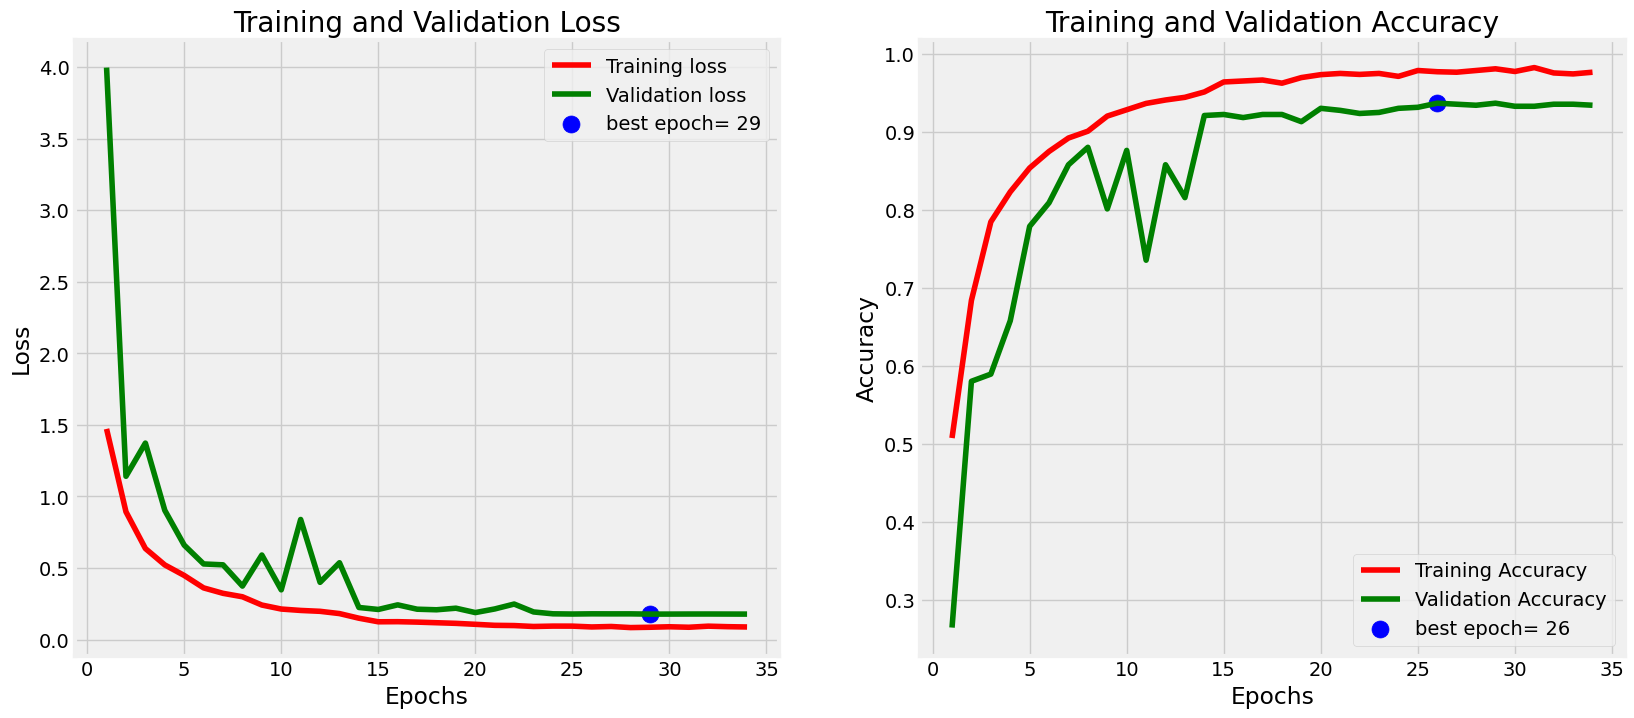

In [29]:
training_acc = history.history['accuracy']
training_loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Select the min loss and the max accuracy achieved in the validation
index_loss = np.argmin(validation_loss)
val_lowest = validation_loss[index_loss]
index_acc = np.argmax(validation_acc)
acc_highest = validation_acc[index_acc]

# Arrange for plotting
epochs = [i+1 for i in range(len(training_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label= 'Training loss')
plt.plot(epochs, validation_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, validation_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()